# Predicting electricity carbon intensity at a given time and place (test = Germany)

## Import libraries and modules

In [ ]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers, models, layers
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from google.cloud import storage

In [ ]:
# Installing faspapi unicorn
# !pip install fastapi uvicorn
#!pip install --upgrade typing_extensions

## 1. Extract hourly carbon intensity and electricity sources data from Electricity Maps API

In [19]:
"""
get extended carbon intensity data (15 jan 2025 to 15 mar 2025) by querying consecutive 24-hour windows
- loops over the overall period (15 jan to 15 mar 2025), making separate API calls for each 24-hour interval.
- concatenates the results into a single dataframe.
- drops unwanted columns.
"""

def get_carbon_intensity_past_range(start_str, end_str, zone="DE", resolution="hour"):
    # Use the past-range endpoint for carbon intensity data
    base_url = "https://api.electricitymap.org/v3/carbon-intensity/past-range"
    url = f"{base_url}?zone={zone}&start={start_str}&end={end_str}&resolution={resolution}"
    response = requests.get(url, headers={"auth-token": "covOsi4VsXc8mIdsxumr"})
    data = response.json()
    # Extract the records from the "data" key as per API documentation
    return pd.DataFrame(data.get("data", []))

# Define the overall period: from 15 January 2025 to 15 March 2025 (full day)
overall_start = datetime.strptime("2025-01-15T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")
overall_end   = datetime.strptime("2025-03-16T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")

# Calculate and print the number of days in the period
total_days = (overall_end - overall_start).days
print(f"Total days in period: {total_days}")

# Use 10-day batches (the API’s maximum range per call)
batch_delta = timedelta(days=10)
dfs = []
current_start = overall_start

while current_start < overall_end:
    current_end = current_start + batch_delta
    if current_end > overall_end:
        current_end = overall_end
    start_str = current_start.strftime("%Y-%m-%dT%H:%M:%S") + ".000Z"
    end_str   = current_end.strftime("%Y-%m-%dT%H:%M:%S") + ".000Z"
    print(f"Requesting carbon intensity data from {start_str} to {end_str}")
    df_temp = get_carbon_intensity_past_range(start_str, end_str)
    dfs.append(df_temp)
    current_start = current_end

df_de_carbon_intensity = pd.concat(dfs, ignore_index=True)

# Drop unwanted columns (keep updatedAt for deduplication)
unwanted_cols = ["createdAt", "emissionFactorType", "isEstimated", "estimationMethod"]
df_de_carbon_intensity = df_de_carbon_intensity.drop(columns=unwanted_cols, errors="ignore")

# Standardize the "datetime" column to a canonical ISO format (forcing milliseconds to .000Z)
df_de_carbon_intensity["datetime"] = pd.to_datetime(df_de_carbon_intensity["datetime"])\
    .dt.strftime("%Y-%m-%dT%H:%M:%S.000Z")

# Convert "updatedAt" to datetime, sort descending (latest first), and drop duplicates on "datetime"
df_de_carbon_intensity["updatedAt"] = pd.to_datetime(df_de_carbon_intensity["updatedAt"])
df_de_carbon_intensity = df_de_carbon_intensity.sort_values("updatedAt", ascending=False)
df_de_carbon_intensity = df_de_carbon_intensity.drop_duplicates(subset=["datetime"], keep="first")

print("Carbon intensity data shape:", df_de_carbon_intensity.shape)

Total days in period: 60
Requesting carbon intensity data from 2025-01-15T00:00:00.000Z to 2025-01-25T00:00:00.000Z
Requesting carbon intensity data from 2025-01-25T00:00:00.000Z to 2025-02-04T00:00:00.000Z
Requesting carbon intensity data from 2025-02-04T00:00:00.000Z to 2025-02-14T00:00:00.000Z
Requesting carbon intensity data from 2025-02-14T00:00:00.000Z to 2025-02-24T00:00:00.000Z
Requesting carbon intensity data from 2025-02-24T00:00:00.000Z to 2025-03-06T00:00:00.000Z
Requesting carbon intensity data from 2025-03-06T00:00:00.000Z to 2025-03-16T00:00:00.000Z
Carbon intensity data shape: (1440, 4)


In [20]:
"""
get extended electricity sources data (15 jan 2025 to 15 mar 2025) by querying consecutive 24-hour windows
- loops over the overall period (15 jan to 15 mar 2025), making separate API calls for each 24-hour interval.
- concatenates the results into a single dataframe.
- drops unwanted columns: updatedAt, createdAt.
- assigns the result to df_de_electricity_sources.
"""

def get_power_breakdown_past_range(start_str, end_str, zone="DE", resolution="hour"):
    # Use the past-range endpoint for power breakdown data
    base_url = "https://api.electricitymap.org/v3/power-breakdown/past-range"
    url = f"{base_url}?zone={zone}&start={start_str}&end={end_str}&resolution={resolution}"
    response = requests.get(url, headers={"auth-token": "covOsi4VsXc8mIdsxumr"})
    data = response.json()
    # Flatten nested JSON; extract records from the "data" key
    df = pd.json_normalize(data.get("data", []))
    return df

# Define the overall period: from 15 January 2025 to 15 March 2025 (full day)
overall_start = datetime.strptime("2025-01-15T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")
overall_end   = datetime.strptime("2025-03-16T00:00:00.000Z", "%Y-%m-%dT%H:%M:%S.%fZ")

batch_delta = timedelta(days=10)
dfs = []
current_start = overall_start

while current_start < overall_end:
    current_end = current_start + batch_delta
    if current_end > overall_end:
        current_end = overall_end
    start_str = current_start.strftime("%Y-%m-%dT%H:%M:%S") + ".000Z"
    end_str   = current_end.strftime("%Y-%m-%dT%H:%M:%S") + ".000Z"
    print(f"Requesting electricity sources data from {start_str} to {end_str}")
    df_temp = get_power_breakdown_past_range(start_str, end_str)
    dfs.append(df_temp)
    current_start = current_end

df_full_power = pd.concat(dfs, ignore_index=True)

# Standardize the "datetime" column
df_full_power["datetime"] = pd.to_datetime(df_full_power["datetime"])\
    .dt.strftime("%Y-%m-%dT%H:%M:%S.000Z")

# If updatedAt exists, convert it, sort descending and drop duplicates on "datetime"
if "updatedAt" in df_full_power.columns:
    df_full_power["updatedAt"] = pd.to_datetime(df_full_power["updatedAt"])
    df_full_power = df_full_power.sort_values("updatedAt", ascending=False)
    df_full_power = df_full_power.drop_duplicates(subset=["datetime"], keep="first")

# Select the desired columns: "datetime", "updatedAt", and specific consumption keys
e_consumption_types = [
    "powerConsumptionBreakdown.nuclear",
    "powerConsumptionBreakdown.geothermal",
    "powerConsumptionBreakdown.biomass",
    "powerConsumptionBreakdown.coal",
    "powerConsumptionBreakdown.wind",
    "powerConsumptionBreakdown.solar",
    "powerConsumptionBreakdown.hydro",
    "powerConsumptionBreakdown.gas",
    "powerConsumptionBreakdown.oil"
]
df_de_electricity_sources = df_full_power[["datetime", "updatedAt"] + e_consumption_types].copy()

print("Electricity sources data shape:", df_de_electricity_sources.shape)

Requesting electricity sources data from 2025-01-15T00:00:00.000Z to 2025-01-25T00:00:00.000Z
Requesting electricity sources data from 2025-01-25T00:00:00.000Z to 2025-02-04T00:00:00.000Z
Requesting electricity sources data from 2025-02-04T00:00:00.000Z to 2025-02-14T00:00:00.000Z
Requesting electricity sources data from 2025-02-14T00:00:00.000Z to 2025-02-24T00:00:00.000Z
Requesting electricity sources data from 2025-02-24T00:00:00.000Z to 2025-03-06T00:00:00.000Z
Requesting electricity sources data from 2025-03-06T00:00:00.000Z to 2025-03-16T00:00:00.000Z
Electricity sources data shape: (1440, 11)


## 2. Merge datasets on datetime (time-consistency)

In [24]:
"""
merge datasets & export csv
- merges df_de_carbon_intensity and df_de_electricity_sources on 'datetime'.
- exports the merged dataframe to a csv file.
"""
# check duplicates for carbon intensity data
dup_carbon = df_de_carbon_intensity["datetime"].value_counts()
print("duplicate counts in carbon intensity data:")
if dup_carbon[dup_carbon > 1].empty:
    print("no duplicates found")
else:
    print(dup_carbon[dup_carbon > 1])

# check duplicates for electricity sources data
dup_power = df_de_electricity_sources["datetime"].value_counts()
print("duplicate counts in electricity sources data:")
if dup_power[dup_power > 1].empty:
    print("no duplicates found")
else:
    print(dup_power[dup_power > 1])

duplicate counts in carbon intensity data:
no duplicates found
duplicate counts in electricity sources data:
no duplicates found


In [27]:
# merge the two dataframes on datetime (inner join)
df_de_merged = pd.merge(df_de_carbon_intensity, df_de_electricity_sources, on="datetime", suffixes=("_carbon", "_electricity"))


In [56]:
# check how the merged df looks like
df_de_merged.head(10)

,zone,carbonIntensity,datetime,updatedAt_carbon,updatedAt_electricity,powerConsumptionBreakdown.nuclear,powerConsumptionBreakdown.geothermal,powerConsumptionBreakdown.biomass,powerConsumptionBreakdown.coal,powerConsumptionBreakdown.wind,powerConsumptionBreakdown.solar,powerConsumptionBreakdown.hydro,powerConsumptionBreakdown.gas,powerConsumptionBreakdown.oil
0,DE,570,2025-03-13T05:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,3230,23,5244,19703,6375,71,3518,15791,430
1,DE,521,2025-03-14T19:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,2211,22,5118,18023,11196,0,3046,14116,337
2,DE,509,2025-03-14T18:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,2440,22,5153,18011,10512,5,3554,14513,384
3,DE,480,2025-03-13T13:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,2383,22,4833,18502,6673,11364,2784,13071,328
4,DE,436,2025-03-14T10:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,1915,21,4866,17116,3811,18480,3052,11765,329
5,DE,513,2025-03-13T15:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,2563,22,5055,18646,6784,5953,3250,14644,336
6,DE,519,2025-03-13T16:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,3204,22,5109,18562,6739,2126,4317,15787,386
7,DE,459,2025-03-13T09:00:00.000Z,2025-03-23 05:48:45.025000+00:00,2025-03-23 05:48:45.025000+00:00,1771,21,4638,17902,4852,16316,2443,12151,319
8,DE,555,2025-03-13T19:00:00.000Z,2025-03-23 05:48:33.339000+00:00,2025-03-23 05:48:33.339000+00:00,2205,23,5142,19526,7035,2,3659,15489,363
9,DE,516,2025-03-13T07:00:00.000Z,2025-03-23 05:48:33.339000+00:00,2025-03-23 05:48:33.339000+00:00,2092,22,4964,19067,5395,7273,2927,14918,332


In [ ]:
# checking for nans
nan_counts = df_de_merged.isnull().sum()
print(nan_counts)

In [31]:
# export merged dataframe to csv
df_de_merged.to_csv("df_de_merged.csv", index=False)
print("merged data exported to 'df_de_merged.csv'")


merged data exported to 'df_de_merged.csv'


## 3. Basic info and visualization

In [197]:
"""
basic info
- prints basic characteristics of the merged dataset.
"""

print("shape:", df_de_merged.shape)
print("columns:", df_de_merged.columns.tolist())
print("df_de_merged data types:")
print(df_de_merged.dtypes)


shape: (86400, 12)
columns: ['zone', 'carbonIntensity', 'datetime', 'powerConsumptionBreakdown.nuclear', 'powerConsumptionBreakdown.geothermal', 'powerConsumptionBreakdown.biomass', 'powerConsumptionBreakdown.coal', 'powerConsumptionBreakdown.wind', 'powerConsumptionBreakdown.solar', 'powerConsumptionBreakdown.hydro', 'powerConsumptionBreakdown.gas', 'powerConsumptionBreakdown.oil']
df_de_merged data types:
zone                                    object
carbonIntensity                          int64
datetime                                object
powerConsumptionBreakdown.nuclear        int64
powerConsumptionBreakdown.geothermal     int64
powerConsumptionBreakdown.biomass        int64
powerConsumptionBreakdown.coal           int64
powerConsumptionBreakdown.wind           int64
powerConsumptionBreakdown.solar          int64
powerConsumptionBreakdown.hydro          int64
powerConsumptionBreakdown.gas            int64
powerConsumptionBreakdown.oil            int64
dtype: object


In [ ]:
# ensure the datetime column is in datetime format
df_de_merged['datetime'] = pd.to_datetime(df_de_merged['datetime'])

# sort the dataframe chronologically and reset the index
df_de_merged = df_de_merged.sort_values(by='datetime', ascending=True).reset_index(drop=True)


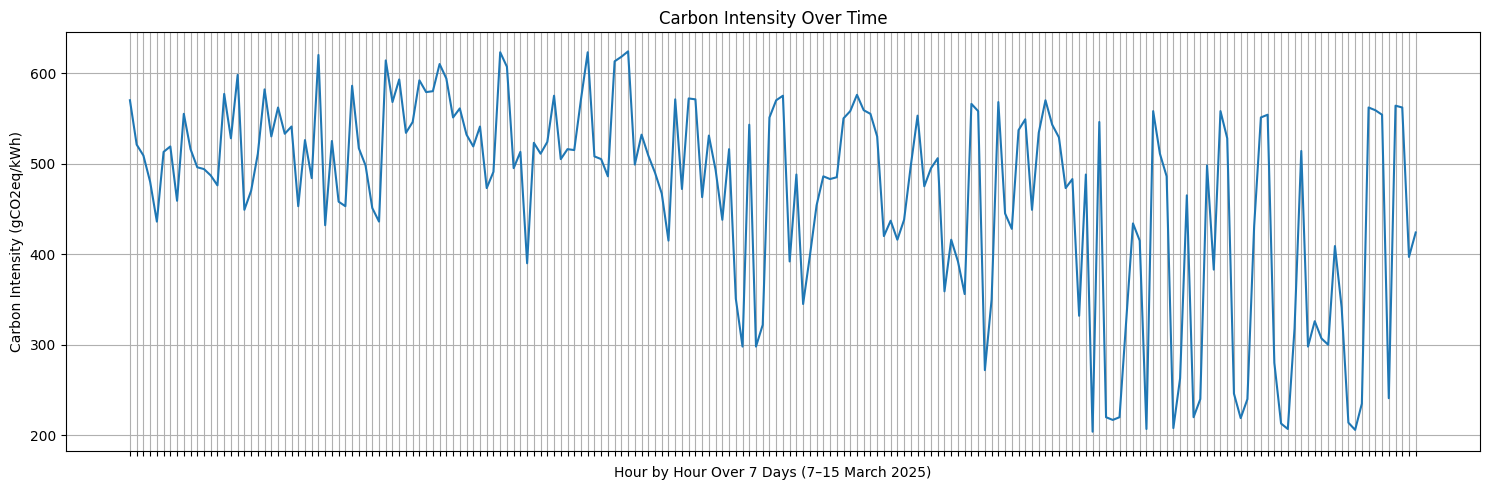

You can see how consumed electricity's carbon intensity varies over time (only 7–15 March shown).


In [ ]:
"""
vizualization
- looking at the merged dataset from various angles
"""

# visualize carbon intensity over a 7 day extract period

# filter rows for 7 march through 15 march (inclusive)
mask = (df_de_merged['datetime'] >= '2025-03-07') & (df_de_merged['datetime'] <= '2025-03-15')
df_filtered = df_de_merged[mask]

plt.figure(figsize=(15,5))
plt.plot(df_filtered['datetime'], df_filtered['carbonIntensity'])

plt.title('Carbon Intensity Over Time')
plt.xlabel('Hour by Hour Over 7 Days (7–15 March 2025)')
plt.ylabel('Carbon Intensity (gCO2eq/kWh)')

# remove x-axis tick labels (but keep the axis label)
ax = plt.gca()
ax.set_xticklabels([])

plt.grid(True)
plt.tight_layout()
plt.show()

print("You can see how consumed electricity's carbon intensity varies over time (only 7–15 March shown).")

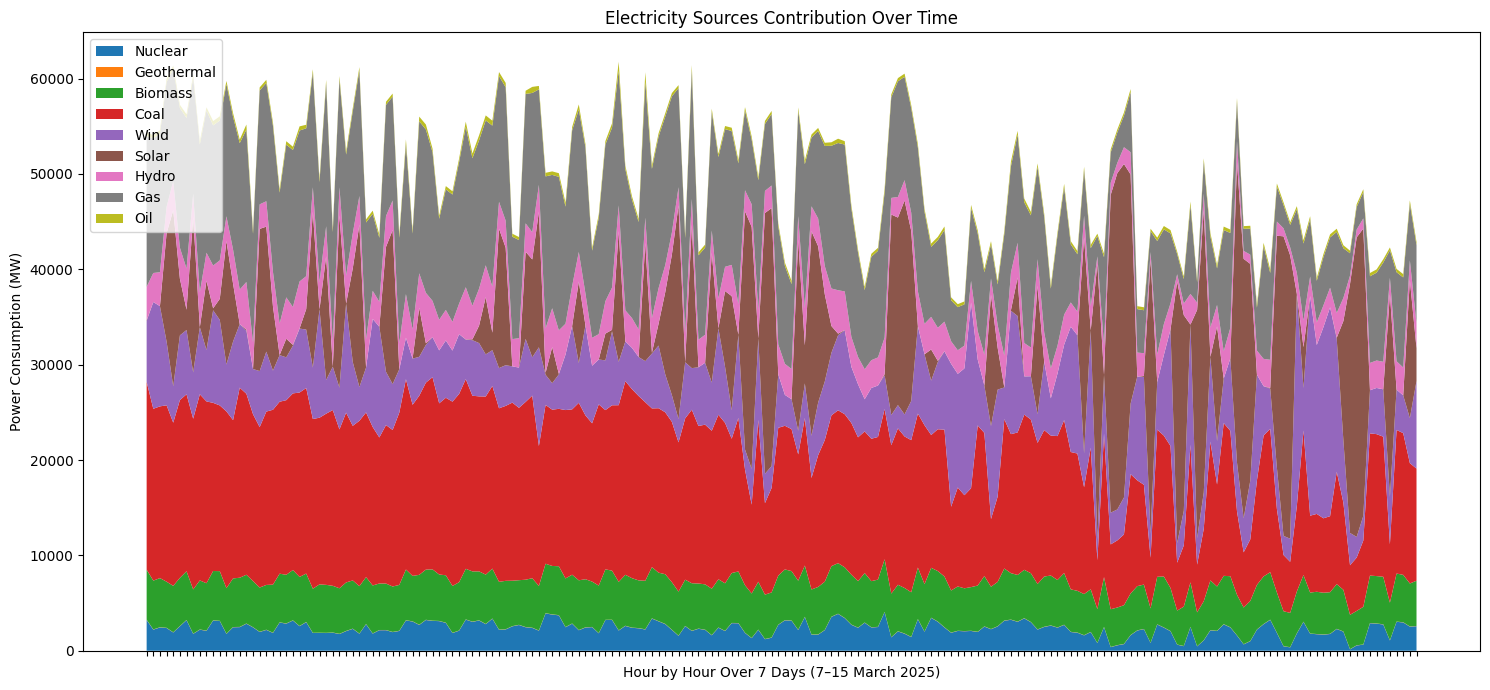

You can see how consumed electricity's sources also vary over time (only 7–15 March shown).


In [ ]:
# visualize electricity sources over a 7 day extract period

# filter rows for 7 march through 15 march (inclusive)
mask = (df_de_merged['datetime'] >= '2025-03-07') & (df_de_merged['datetime'] <= '2025-03-15')
df_filtered = df_de_merged[mask]

# define the sources
sources = [
    'powerConsumptionBreakdown.nuclear',
    'powerConsumptionBreakdown.geothermal',
    'powerConsumptionBreakdown.biomass',
    'powerConsumptionBreakdown.coal',
    'powerConsumptionBreakdown.wind',
    'powerConsumptionBreakdown.solar',
    'powerConsumptionBreakdown.hydro',
    'powerConsumptionBreakdown.gas',
    'powerConsumptionBreakdown.oil'
]

plt.figure(figsize=(15, 7))
plt.stackplot(df_filtered['datetime'],
              [df_filtered[source] for source in sources],
              labels=[source.split('.')[-1].capitalize() for source in sources])

plt.legend(loc='upper left')
plt.title('Electricity Sources Contribution Over Time')
plt.xlabel('Hour by Hour Over 7 Days (7–15 March 2025)')
plt.ylabel('Power Consumption (MW)')

# hide x-axis tick labels otherwise chart gets crowded
ax = plt.gca()
ax.set_xticklabels([])

plt.tight_layout()
plt.show()

print("You can see how consumed electricity's sources also vary over time (only 7–15 March shown).")

/var/folders/ry/wtmkg2_s1mdgh59g_p3jdq0w0000gn/T/ipykernel_71754/3449077258.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([s.split('.')[-1].capitalize() for s in sources], rotation=45)


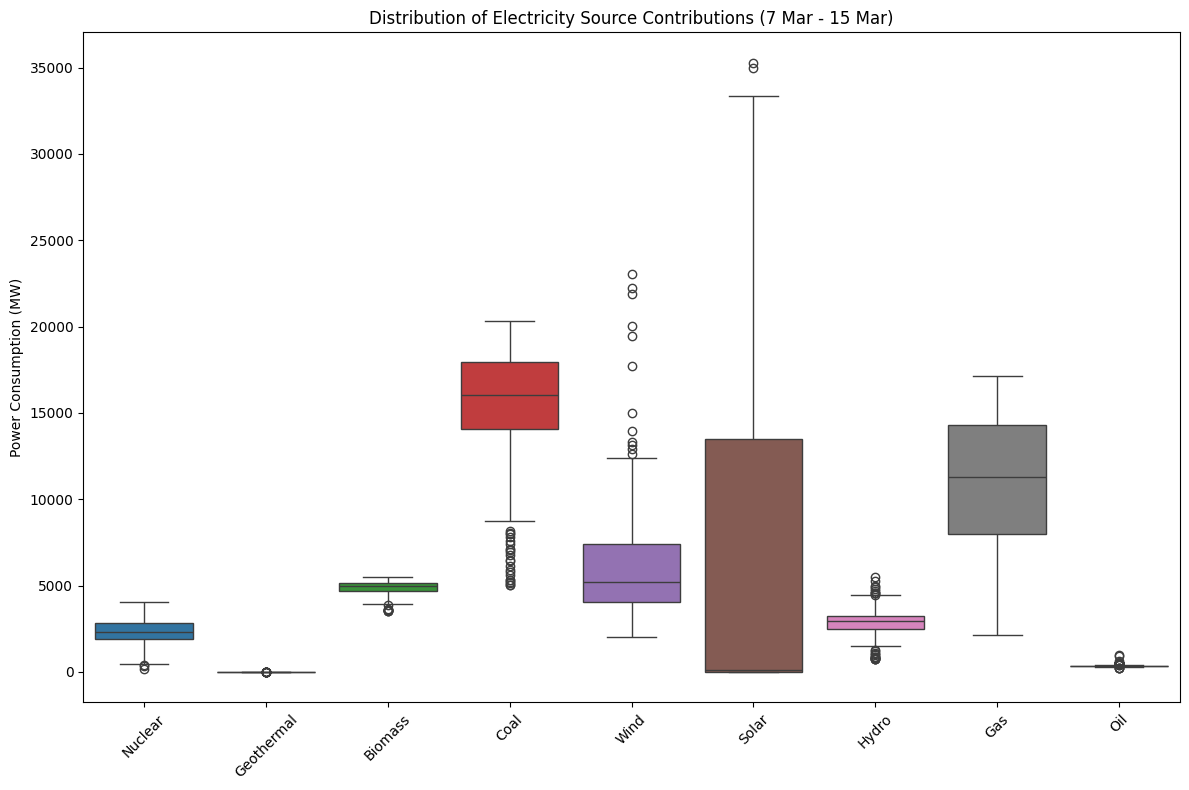

You can see that among the biggest variations in elecricity sources come from solar (sometimes the sun doesn't shine) and wind (sometimes the wind blows harder, sometimes not). Coal and gas exhibit huge variation in consequence as they are the sources sovling for this intermittency. 


In [44]:
# visualize dispersion of elecricity over a 7 day  period


# filter data for the period 7 march to 15 march (inclusive)
mask = (df_de_merged['datetime'] >= '2025-03-07') & (df_de_merged['datetime'] <= '2025-03-15')
df_filtered = df_de_merged[mask]

plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=df_filtered[sources])
# replace x-axis tick labels to remove 'powerConsumptionBreakdown.' prefix
ax.set_xticklabels([s.split('.')[-1].capitalize() for s in sources], rotation=45)
plt.title('Distribution of Electricity Source Contributions (7 Mar - 15 Mar)')
plt.ylabel('Power Consumption (MW)')
plt.tight_layout()
plt.show()

print("You can see that among the biggest variations in elecricity sources come from solar (sometimes the sun doesn't shine) and wind (sometimes the wind blows harder, sometimes not). Coal and gas exhibit huge variation in consequence as they are the sources sovling for this intermittency. ")

## 4. Feature preprocessing

In [45]:

"""
compress df_de_merged
- downcasts numeric columns (int64/float64) to lower memory types, except datetime columns.
"""

def compress_df(df):
    df_compressed = df.copy()
    for col in df_compressed.columns:
        # skip datetime columns
        if pd.api.types.is_datetime64_any_dtype(df_compressed[col]):
            continue
        if pd.api.types.is_numeric_dtype(df_compressed[col]):
            if pd.api.types.is_integer_dtype(df_compressed[col]):
                df_compressed[col] = pd.to_numeric(df_compressed[col], downcast='integer')
            elif pd.api.types.is_float_dtype(df_compressed[col]):
                df_compressed[col] = pd.to_numeric(df_compressed[col], downcast='float')
    return df_compressed

df_de_merged = compress_df(df_de_merged)
print("compressed dtypes:")
print(df_de_merged.dtypes)


compressed dtypes:
zone                                                 object
carbonIntensity                                       int16
datetime                                             object
updatedAt_carbon                        datetime64[ns, UTC]
updatedAt_electricity                   datetime64[ns, UTC]
powerConsumptionBreakdown.nuclear                     int16
powerConsumptionBreakdown.geothermal                   int8
powerConsumptionBreakdown.biomass                     int16
powerConsumptionBreakdown.coal                        int16
powerConsumptionBreakdown.wind                        int32
powerConsumptionBreakdown.solar                       int32
powerConsumptionBreakdown.hydro                       int16
powerConsumptionBreakdown.gas                         int16
powerConsumptionBreakdown.oil                         int16
dtype: object


In [51]:
"""
cell: feature extraction and normalization (stateless preprocessor)
- extracts time features (cyclical and one-hot encoded),
- extracts energy features,
- computes relative percentages for energy sources (each divided by the row sum),
- returns a fixed-order dataframe.
"""

def extract_time_energy_features(x):
    x = x.copy()
    # time features
    x['datetime'] = pd.to_datetime(x['datetime'])
    x['hour'] = x['datetime'].dt.hour
    x['weekday'] = x['datetime'].dt.weekday
    x['hour_sin'] = np.sin(2 * np.pi * x['hour'] / 24)
    x['hour_cos'] = np.cos(2 * np.pi * x['hour'] / 24)
    x['weekday_sin'] = np.sin(2 * np.pi * x['weekday'] / 7)
    x['weekday_cos'] = np.cos(2 * np.pi * x['weekday'] / 7)
    # one-hot encoding for time
    hour_dummies = pd.get_dummies(x['hour'], prefix='hour')
    weekday_dummies = pd.get_dummies(x['weekday'], prefix='weekday')
    expected_hour_cols = [f'hour_{i}' for i in range(24)]
    expected_weekday_cols = [f'weekday_{i}' for i in range(7)]
    hour_dummies = hour_dummies.reindex(columns=expected_hour_cols, fill_value=0)
    weekday_dummies = weekday_dummies.reindex(columns=expected_weekday_cols, fill_value=0)
    time_order = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos'] + expected_hour_cols + expected_weekday_cols
    time_features = pd.concat([x[['hour_sin','hour_cos','weekday_sin','weekday_cos']], hour_dummies, weekday_dummies], axis=1)
    time_features = time_features[time_order]

    # energy features: from df_de_electricity_sources, keys assumed to be in x
    energy_cols = [
        "powerConsumptionBreakdown.nuclear",
        "powerConsumptionBreakdown.geothermal",
        "powerConsumptionBreakdown.biomass",
        "powerConsumptionBreakdown.coal",
        "powerConsumptionBreakdown.wind",
        "powerConsumptionBreakdown.solar",
        "powerConsumptionBreakdown.hydro",
        "powerConsumptionBreakdown.gas",
        "powerConsumptionBreakdown.oil"
    ]
    energy_features = x[energy_cols].copy()
    # compute the row-wise sum for energy sources
    energy_sum = energy_features.sum(axis=1).replace(0, np.nan)
    # compute relative percentage (0 to 1)
    energy_relative = energy_features.div(energy_sum, axis=0).fillna(0)

    final_order = time_order + energy_cols
    final_features = pd.concat([time_features, energy_relative], axis=1)
    final_features = final_features[final_order]
    return final_features

# pure transformer without state using function transformer
feature_transformer = FunctionTransformer(extract_time_energy_features, validate=False)

# build pipeline (stateless preprocessor)
features_pipeline = Pipeline([
    ('feature_extraction_and_normalization', feature_transformer)
])

# test on the merged dataframe (df_de_merged should have both 'datetime' and energy columns)
df_processed = features_pipeline.transform(df_de_merged)
print("preprocessed features shape:", df_processed.shape)


preprocessed features shape: (1440, 44)


## 5. Train test split

In [52]:
# Chronological split
split_ratio = 0.20
test_length = int(len(df_de_merged) * split_ratio)
val_length = int((len(df_de_merged) - test_length) * split_ratio)
train_length = len(df_de_merged) - val_length - test_length

df_train = df_de_merged.iloc[:train_length, :].copy()
df_val   = df_de_merged.iloc[train_length: train_length + val_length, :].copy()
df_test  = df_de_merged.iloc[train_length + val_length:, :].copy()

print("train shape:", df_train.shape)
print("validation shape:", df_val.shape)
print("test shape:", df_test.shape)

# Define target variables
y_train = df_train['carbonIntensity']
y_val   = df_val['carbonIntensity']
y_test  = df_test['carbonIntensity']


train shape: (922, 14)
validation shape: (230, 14)
test shape: (288, 14)


In [53]:
# define target scaler and transform target variables
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled   = target_scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled  = target_scaler.transform(y_test.values.reshape(-1, 1))

# preprocess the data splits using the state-less features pipeline
X_train_processed = features_pipeline.transform(df_train)
X_val_processed = features_pipeline.transform(df_val)
X_test_processed = features_pipeline.transform(df_test)

print("processed feature shapes:")
print("X_train_processed:", X_train_processed.shape)
print("X_val_processed:", X_val_processed.shape)
print("X_test_processed:", X_test_processed.shape)


processed feature shapes:
X_train_processed: (922, 44)
X_val_processed: (230, 44)
X_test_processed: (288, 44)


## 6. Build and train the model

In [54]:
"""
- initializes a deep neural network.
"""

# initialize model
def initialize_model(input_shape: tuple):
    reg = regularizers.l1_l2(l1=0.005)
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    model.add(layers.Dense(100, activation="relu", kernel_regularizer=reg))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(50, activation="relu"))
    model.add(layers.BatchNormalization(momentum=0.9))
    model.add(layers.Dropout(rate=0.1))
    model.add(layers.Dense(1, activation="linear"))
    print("✅ model initialized")
    return model

input_shape = (X_train_processed.shape[1],)
model = initialize_model(input_shape)
model.summary()


✅ model initialized


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │         4,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,201 (39.85 KB)

 Trainable params: 9,901 (38.68 KB)

 Non-trainable params: 300 (1.17 KB)

In [55]:
# compile model
learning_rate = 0.0005
batch_size = 256
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mae"])

# early stopping callback
es = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# train on scaled targets
history = model.fit(
    X_train_processed,
    y_train_scaled,
    validation_data=(X_val_processed, y_val_scaled),
    epochs=100,
    batch_size=batch_size,
    callbacks=[es],
    verbose=1
)


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 5.2382 - mae: 1.3829 - val_loss: 2.3948 - val_mae: 0.3062
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2583 - mae: 1.1302 - val_loss: 2.3415 - val_mae: 0.2417
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8232 - mae: 1.0047 - val_loss: 2.4097 - val_mae: 0.3388
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4058 - mae: 0.8601 - val_loss: 2.4772 - val_mae: 0.4222
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.


## 7. Predict and evaluate the model

In [ ]:
# evaluate in scaled units
val_metrics_scaled = model.evaluate(X_val_processed, y_val_scaled, verbose=0)
test_metrics_scaled = model.evaluate(X_test_processed, y_test_scaled, verbose=0)
print("mae val (scaled):", round(val_metrics_scaled[1], 2))
print("mae test (scaled):", round(test_metrics_scaled[1], 2))

# predict on test set (reverse scaled to find back the right, unscaled units)
y_pred_scaled = model.predict(X_test_processed)
# inverse transform predictions and test targets to original gco2eq/kwh units
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_original = target_scaler.inverse_transform(y_test_scaled)

mse = mean_squared_error(y_test_original, y_pred)
mae = mean_absolute_error(y_test_original, y_pred)
print("mae test (gco2eq/kwh):", round(mae, 2))
print("mse test (gco2eq/kwh):", round(mse, 2))


mae val (scaled): 0.23
mae test (scaled): 0.16
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x2eff0cf70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x2eff0cf70>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.

In [215]:
# compute the average carbon intensity over the period
mean_carbon = df_de_merged['carbonIntensity'].mean()
print("mean carbon intensity (gco2eq/kwh):", round(mean_carbon, 2))

# assume mae is the test MAE in gco2eq/kwh (e.g., 42.51)
# compute the percentage error
percentage_error = (mae / mean_carbon) * 100
print("mae test as percentage of average carbon intensity:", round(percentage_error, 2), "%")
print("Ok the mae is around 11% of the mean carbon intensity, not great but not too bad")

mean carbon intensity (gco2eq/kwh): 383.0
mae test as percentage of average carbon intensity: 11.1 %
Ok the mae is around 11% of the mean carbon intensity, not great but not too bad


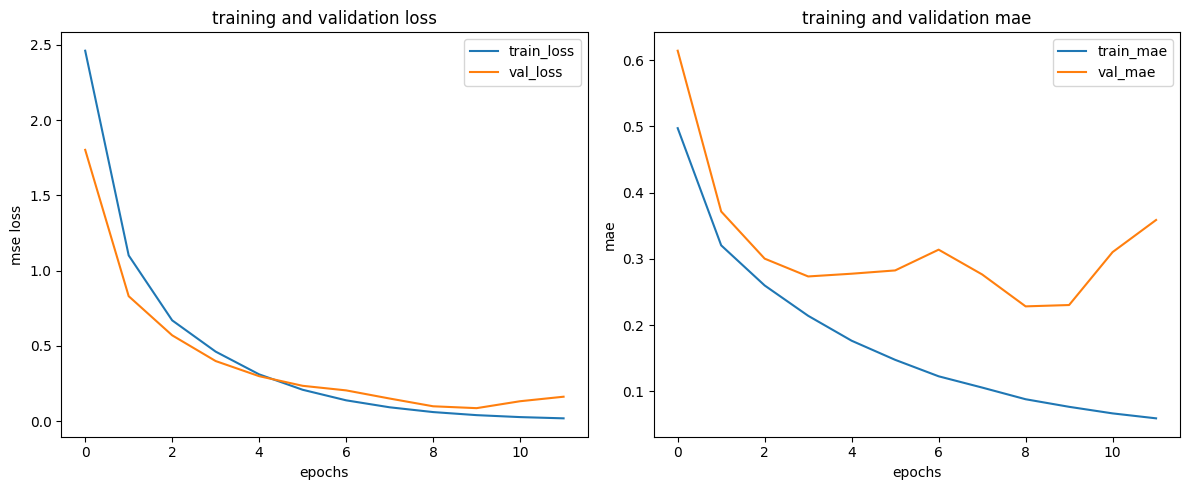

In [216]:
# Plot training history: loss and MAE

plt.figure(figsize=(12, 5))

# left: training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('mse loss')
plt.title('training and validation loss')
plt.legend()

# right: training and validation mae
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.title('training and validation mae')
plt.legend()

plt.tight_layout()
plt.show()


y_pred min: 387.0226 max: 458.80518
y_test_original min: 437.0 max: 459.0


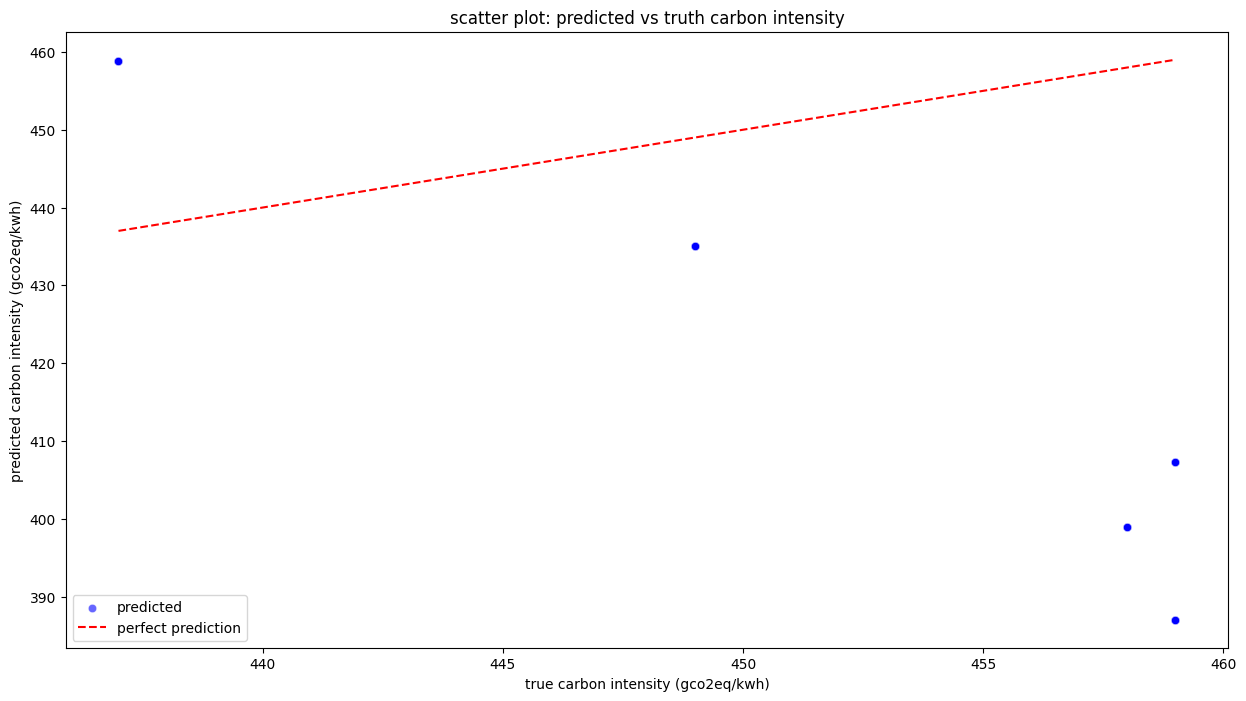

In [217]:
#visualization of predictions

# print the range of predictions and true values
print("y_pred min:", np.min(y_pred), "max:", np.max(y_pred))
print("y_test_original min:", np.min(y_test_original), "max:", np.max(y_test_original))

plt.figure(figsize=(15, 8))
sns.scatterplot(x=y_test_original.flatten(), y=y_pred.flatten(), color='blue', alpha=0.6, label='predicted')

plt.xlabel("true carbon intensity (gco2eq/kwh)")
plt.ylabel("predicted carbon intensity (gco2eq/kwh)")
plt.title("scatter plot: predicted vs truth carbon intensity")

# overlay a perfect prediction line
min_val = np.min(y_test_original)
max_val = np.max(y_test_original)
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="perfect prediction")
plt.legend()

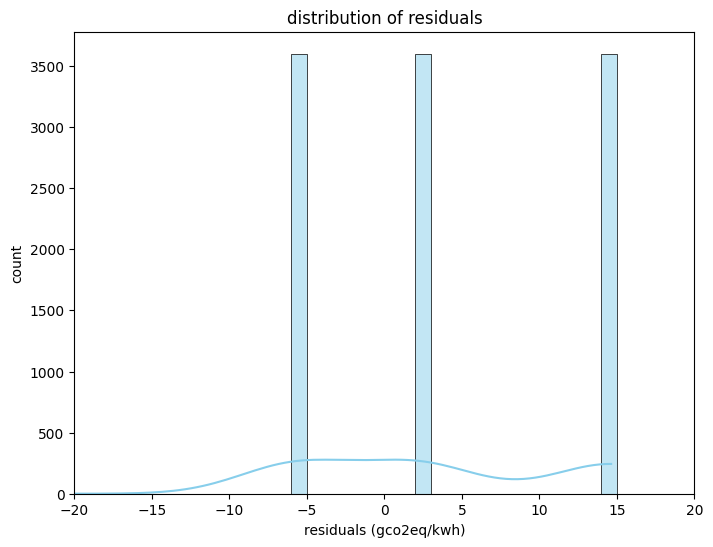

In [218]:
# plot residuals distribution
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=np.arange(-20, 20, 1), kde=True, color="skyblue")
plt.xlim(-20, 20)
plt.xlabel("residuals (gco2eq/kwh)")
plt.ylabel("count")
plt.title("distribution of residuals")
plt.show()

In [210]:
# example input for a specific datetime with sample energy mix values
sample_input = {
    "datetime": "2025-04-12T12:00:00.000Z",
    "powerConsumptionBreakdown.nuclear": 50,
    "powerConsumptionBreakdown.geothermal": 10,
    "powerConsumptionBreakdown.biomass": 100,
    "powerConsumptionBreakdown.coal": 200,
    "powerConsumptionBreakdown.wind": 300,
    "powerConsumptionBreakdown.solar": 20,
    "powerConsumptionBreakdown.hydro": 400,
    "powerConsumptionBreakdown.gas": 150,
    "powerConsumptionBreakdown.oil": 30
}

sample_df = pd.DataFrame([sample_input])
sample_features = features_pipeline.transform(sample_df)
sample_pred_scaled = model.predict(sample_features)
sample_pred = target_scaler.inverse_transform(sample_pred_scaled)
print("predicted carbon intensity for 12 april 2025 at 12:00:", sample_pred[0][0], "gco2eq/kwh")

1/1 [==============================] - 0s 42ms/step
predicted carbon intensity for 12 april 2025 at 12:00: 371.4726 gco2eq/kwh


## 8. FastAPI draft code

In [221]:
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn

app = FastAPI()

class PredictionInput(BaseModel):
    datetime: str
    powerConsumptionBreakdown_nuclear: float
    powerConsumptionBreakdown_geothermal: float
    powerConsumptionBreakdown_biomass: float
    powerConsumptionBreakdown_coal: float
    powerConsumptionBreakdown_wind: float
    powerConsumptionBreakdown_solar: float
    powerConsumptionBreakdown_hydro: float
    powerConsumptionBreakdown_gas: float
    powerConsumptionBreakdown_oil: float

@app.post("/predict")
def predict(input_data: PredictionInput):
    data = input_data.dict()
    # rename keys to match expected columns
    mapping = {
        "powerConsumptionBreakdown_nuclear": "powerConsumptionBreakdown.nuclear",
        "powerConsumptionBreakdown_geothermal": "powerConsumptionBreakdown.geothermal",
        "powerConsumptionBreakdown_biomass": "powerConsumptionBreakdown.biomass",
        "powerConsumptionBreakdown_coal": "powerConsumptionBreakdown.coal",
        "powerConsumptionBreakdown_wind": "powerConsumptionBreakdown.wind",
        "powerConsumptionBreakdown_solar": "powerConsumptionBreakdown.solar",
        "powerConsumptionBreakdown_hydro": "powerConsumptionBreakdown.hydro",
        "powerConsumptionBreakdown_gas": "powerConsumptionBreakdown.gas",
        "powerConsumptionBreakdown_oil": "powerConsumptionBreakdown.oil"
    }
    for k, v in mapping.items():
        data[v] = data.pop(k)
    sample_df = pd.DataFrame([data])
    sample_features = features_pipeline.transform(sample_df)
    pred_scaled = model.predict(sample_features)
    pred = target_scaler.inverse_transform(pred_scaled)
    return {"predicted_carbon_intensity": pred[0][0]}

# run the app with: uvicorn.run(app, host="0.0.0.0", port=8000)

ImportError: cannot import name 'Doc' from 'typing_extensions' (/Users/clamence12/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/typing_extensions.py)